In [68]:
!pip install --upgrade pip
!pip install -r requirements.txt -q

In [69]:
import mercury as mr
import polars as pl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, Normalizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from plotly.subplots import make_subplots
from fairlearn.metrics import equalized_odds_ratio, equal_opportunity_difference
from IPython.display import display, HTML, Image
from great_tables import GT, loc, style
from scipy.stats import skew, chisquare

import warnings
from copy import deepcopy

from src.metric_calculation import FairnessMetrics

sns.set()

show_code = mr.Checkbox(value=False, label="Show source code")
app = mr.App(title="PER2024–030: FairnessLens Live", description="Fairness in Machine Learning Models", show_code=show_code.value, continuous_update=False)

mercury.Checkbox

mercury.App

In [70]:
data_file = None

# File upload
data_file = mr.File(label="Upload dataset (CSV)", max_file_size="20MB")
if not data_file.filepath:
    _ = mr.Note(text="After successful upload click the green _Run_ button below.")
    mr.Stop()

emp_df = pd.read_csv(data_file.filepath)
# emp_df = pd.read_csv('datasets/Criteo Fairness Job Ads Dataset/fairjob.csv/criteo_fairness_dataset_2024-01-01_2024-05-20.csv')
column_names = emp_df.columns.tolist()
_ = mr.Note(text="Please select all attributes from the uploaded dataset according to the characteristics. Click the green _Run_ button below to continue the execution.")

# MultiSelect widgets for column classification
_ = mr.Note(text="---")
# print(emp_df)
numerical_columns = mr.MultiSelect(
    label="Select All Numerical Attributes*",
    choices=column_names,
    value=[],
)

categorical_columns = mr.MultiSelect(
    label="Select All Categorical Attributes*",
    choices=column_names,
    value=[],
)
prediction_column = mr.Select(label="Select The Prediction Attribute*", choices=column_names)

_ = mr.Note(text="---")
protected_columns = mr.MultiSelect(label="Select Protected Attributes", choices=column_names, value=[])
_ = mr.Note(text="Not necessary to provide any protected attribute. Later, you can choose to rerun the tool.")

"""print("Numerical attributes:", numerical_columns.value)
print("Categorical attributes:", categorical_columns.value)
print("Prediction attribute:", prediction_column.value)
print("Protected attributes:", protected_columns.value)"""

# Check: Ensure no column is selected in both numerical and categorical
overlap_numerical_categorical = set(numerical_columns.value) & set(categorical_columns.value)
error_message = ""

if overlap_numerical_categorical:
    overlap_str = ", ".join(overlap_numerical_categorical)  # Convert set to comma-separated string
    error_message += f"**Warning:** The following columns are selected as both numerical and categorical: {overlap_str}<br>"

if not prediction_column.value:
    error_message += "**Warning:** No columns selected for prediction.<br>"

if not protected_columns.value:
    mr.Markdown(text=f'##**Info:** No protected attributes selected.')

if not error_message:
    # Convert selected columns to appropriate types
    emp_df[numerical_columns.value] = emp_df[numerical_columns.value].apply(pd.to_numeric, errors='coerce')
    emp_df[categorical_columns.value] = emp_df[categorical_columns.value].astype('category')

numerical_data = emp_df[numerical_columns.value]
categorical_data = emp_df[categorical_columns.value]

Please select all attributes from the uploaded dataset according to the characteristics. Click the green _Run_ button below to continue the execution.

---

mercury.MultiSelect

mercury.MultiSelect

mercury.Select

---

mercury.MultiSelect

Not necessary to provide any protected attribute. Later, you can choose to rerun the tool.

In [71]:
emp_df.dropna(inplace=True)
emp_df = emp_df[:1000]

X = deepcopy(emp_df).drop(prediction_column.value, axis=1)
y = emp_df[prediction_column.value]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [72]:

X = deepcopy(emp_df).drop(prediction_column.value, axis=1).dropna()
y = emp_df[prediction_column.value].dropna()

common_idx = X.index.intersection(y.index)
X = X.loc[common_idx]
y = y.loc[common_idx]

def correlation_ratio(categories, values):
    categories = pd.factorize(categories)[0]
    n = len(values)
    ss_total = np.var(values, ddof=0) * n
    ss_between = np.array([np.mean(values[categories == i])**2 *
                          np.sum(categories == i) for i in np.unique(categories)]).sum()
    ss_between -= (np.mean(values)**2 * n)
    return np.sqrt(ss_between / ss_total) if ss_total != 0 else 0

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

correlations = {}

if not numeric_features.empty:
    num_corr = X[numeric_features].corrwith(y, method='pearson')
    correlations.update(num_corr)

if not categorical_features.empty:
    cat_corr = {}
    for col in categorical_features:
        cat_corr[col] = correlation_ratio(X[col], y)
    correlations.update(cat_corr)

corr_series = pd.Series(correlations).sort_values(ascending=False)

In [73]:
X_train_num, X_test_num = X_train[numerical_columns.value], X_test[numerical_columns.value]
X_train_cat, X_test_cat = X_train[deepcopy(list(categorical_columns.value))], X_test[deepcopy(list(categorical_columns.value))]

scaler = Normalizer()
X_train_scaled_tmp = scaler.fit_transform(X_train_num)
X_test_scaled_tmp = scaler.transform(X_test_num)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded_tmp = encoder.fit_transform(X_train_cat)
X_test_encoded_tmp = encoder.transform(X_test_cat)

X_train_scaled = pd.DataFrame(X_train_scaled_tmp, columns=X_train_num.columns, index=X_train_num.index)
X_test_scaled = pd.DataFrame(X_test_scaled_tmp, columns=X_test_num.columns, index=X_test_num.index)

encoded_feature_names = encoder.get_feature_names_out(X_train_cat.columns)
X_train_encoded = pd.DataFrame(X_train_encoded_tmp, columns=encoded_feature_names, index=X_train_cat.index)
X_test_encoded = pd.DataFrame(X_test_encoded_tmp, columns=encoded_feature_names, index=X_test_cat.index)

X_train_processed = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_test_processed = pd.concat([X_test_scaled, X_test_encoded], axis=1)

In [74]:
classifier = SGDClassifier(random_state=42)
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'learning_rate': ['constant', 'invscaling', 'adaptive', 'optimal'],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'max_iter': [1000, 2000],
    'eta0': [1e-2, 1e-3, 1e-4, 1e-5]
}


grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Start timer
start_time = time.time()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    grid_search.fit(X_train_processed, y_train)  # Training happens here

# Calculate duration
training_time = time.time() - start_time
print(f"Grid search training completed in {training_time:.2f} seconds")

# Get best params (unchanged)
best_params = grid_search.best_params_

Grid Search Progress:   0%|          | 0/5760 [00:00<?, ?it/s]

In [75]:
model = SGDClassifier(**best_params)
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
classes = sorted(y_test.unique())

# Create confusion matrix heatmap
conf_fig = go.Figure(go.Heatmap(
    z=conf_matrix,
    colorbar=dict(
        x=0.45,  # Positions between subplots
        y=0.5,
        len=0.7
    ),
    x=[f'Predicted {"false" if c == 0 else "true"}' for c in classes],
    y=[f'Actual {"false" if c == 0 else "true"}' for c in classes],
    colorscale='Blues',
    text=conf_matrix,
    texttemplate="%{text}",
    hovertemplate="Actual: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>"
))
conf_fig.update_layout(
    title='Prediction Distribution',
    width=500,
    height=500
)

# Create metrics radar chart
metrics_fig = go.Figure()
for i, c in enumerate(classes):
    metrics_fig.add_trace(go.Scatterpolar(
        r=[precision[i], recall[i], f1[i]],
        theta=['Precision', 'Recall', 'F1-Score'],
        fill='toself',
        name=f'{"False" if c == 0 else "True"}'
    ))
metrics_fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title='Class Performance Metrics',
    width=600,
    height=400
)

print()

In [76]:
# Assuming model, y_test, and X_test_processed are already defined
metrics = FairnessMetrics(model, y_test, X_test_processed, num_columns=numerical_columns, cat_columns=categorical_columns, protected_columns=protected_columns)

# Fetch false negative and false positive rates for job categories
false_negative_rates = metrics.false_negative_rate()
false_positive_rates = metrics.false_positive_rate()

# Calculate complementary rates (True Positive/Negative Rates)
tpr = {cat: 1 - fnr for cat, fnr in false_positive_rates[protected_columns.value[0]].items()}
tnr = {cat: 1 - fpr for cat, fpr in false_negative_rates[protected_columns.value[0]].items()}

# Create subplot grid (vertical stack)
fig = make_subplots(
    rows=len(protected_columns.value),
    cols=1,
    subplot_titles=[f"<b>{attr}</b> protected attribute" for attr in protected_columns.value],
    vertical_spacing=0.15
)

# Color configuration
COLORS = {'false': '#EF553B', 'true': '#00CC96'}

# Create one plot per protected attribute
for idx, attr in enumerate(protected_columns.value, 1):
    # Get categories for current attribute
    categories = list(false_negative_rates[attr].keys())

    # Get metric values
    false_negative_values = list(false_negative_rates[attr].values())
    false_positive_values = [false_positive_rates[attr].get(cat, 0) for cat in categories]

    # Calculate complementary rates
    tpr = {cat: 1 - fnr for cat, fnr in false_positive_rates[attr].items()}
    tnr = {cat: 1 - fpr for cat, fpr in false_negative_rates[attr].items()}

    # Add traces for each subplot
    fig.add_trace(go.Bar(
        y=categories,
        x=false_positive_values,
        name='False',
        legendgroup='False',
        orientation='h',
        marker_color=COLORS['false'],
        text=[f'{val:.1%}' for val in false_positive_values],
        textposition='inside',
        textfont=dict(color='white'),
        offsetgroup=1,
        showlegend=(idx == 1)  # Only show legend once
    ), row=idx, col=1)

    fig.add_trace(go.Bar(
        y=categories,
        x=[tpr[cat] for cat in categories],
        name='True',
        legendgroup='True',
        orientation='h',
        marker_color=COLORS['true'],
        text=[f'{tpr[cat]:.1%}' for cat in categories],
        textposition='inside',
        textfont=dict(color='white'),
        offsetgroup=1,
        base=false_positive_values,
        showlegend=(idx == 1)
    ), row=idx, col=1)

    fig.add_trace(go.Bar(
        y=categories,
        x=false_negative_values,
        name='False',
        legendgroup='False',
        orientation='h',
        marker_color=COLORS['false'],
        text=[f'{val:.1%}' for val in false_negative_values],
        textposition='inside',
        textfont=dict(color='white'),
        offsetgroup=2,
        showlegend=False
    ), row=idx, col=1)

    fig.add_trace(go.Bar(
        y=categories,
        x=[tnr[cat] for cat in categories],
        name='True',
        legendgroup='True',
        orientation='h',
        marker_color=COLORS['true'],
        text=[f'{tnr[cat]:.1%}' for cat in categories],
        textposition='inside',
        textfont=dict(color='white'),
        offsetgroup=2,
        base=false_negative_values,
        showlegend=False
    ), row=idx, col=1)

    # Add category labels
    for cat_idx, category in enumerate(categories):
        fig.add_annotation(
            x=1.01,
            y=cat_idx+0.15,
            text="<b>Class 1</b>",
            showarrow=False,
            xref="x"+str(idx),
            yref="y"+str(idx),
            xanchor="left",
            font=dict(size=10)
        )
        fig.add_annotation(
            x=1.01,
            y=cat_idx-0.15,
            text="<b>Class 0</b>",
            showarrow=False,
            xref="x"+str(idx),
            yref="y"+str(idx),
            xanchor="left",
            font=dict(size=10)
        )

# Update unified layout
fig.update_layout(
    barmode='group',
    title_text='True/False Positive/Negative rates by Protected Attribute',
    height=400 * len(protected_columns.value),
    plot_bgcolor='white',
    bargap=0.4,
    bargroupgap=0.18,
    legend=dict(
        title='Classification Accuracy:',
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    margin=dict(l=150, r=150)
)

# Update axis properties for all subplots
for i in range(1, len(protected_columns.value)+1):
    fig.update_xaxes(
        range=[0, 1],
        tickformat=".0%",
        showgrid=False,
        row=i,
        col=1
    )
    fig.update_yaxes(
        showgrid=False,
        tickfont_size=12,
        row=i,
        col=1
    )

tprtnr_fig = fig

print()

In [77]:
# Get correlations as a pandas Series
correlation_series = pd.Series(metrics.correlation_to_prediction())

# Get top 3 categories with highest absolute correlation
correlations = (
    correlation_series.abs()
    .sort_values(ascending=False)
)

# Separate categories and their correlation values
categories = correlations.index.tolist()
correlations = correlations.values.tolist()

# Create visualization with enhanced elements
corr_fig = go.Figure()

# Main correlation bars
corr_fig.add_trace(go.Bar(
    x=categories,
    y=correlations,
    marker=dict(
        color=correlations,
        colorscale='Bluered',
        line=dict(color='DarkSlateGrey', width=1.5)
    ),
    text=[f'Correlation: {val:.2f}' for val in correlations],
    textposition='outside',
    textfont=dict(color='black'),
    hoverinfo='text+x'
))

# Reference lines and zones
reference_lines = [
    (0.0, "green", "dash", "Neutral Correlation"),
    (0.5, "orange", "dot", "Strong Positive"),
    (-0.5, "purple", "dot", "Strong Negative")
]

for value, color, dash, name in reference_lines:
    corr_fig.add_hline(
        y=value,
        line=dict(color=color, dash=dash),
        annotation_text=name,
        annotation_position="right"
    )

# Adjust the layout to make the bar plot smaller
corr_fig.update_layout(
    title=dict(
        text="Top Correlations with Prediction Values",
        x=0.,
        font=dict(size=20)
    ),
    xaxis=dict(
        title="Categories",
        tickangle=45,
        gridcolor='lightgray',
        domain=[0.2, 0.8]  # Shrink the horizontal size of the bar plot
    ),
    yaxis=dict(
        title="Correlation Strength",
        range=[-1.1, 1.1],
        gridcolor='lightgray',
        zerolinecolor='black',
        domain=[0.1, 0.9]  # Shrink the vertical size of the bar plot
    ),
    plot_bgcolor='white',
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    ),
    margin=dict(l=50, r=50, t=50, b=100)  # Adjust margins to fit everything nicely
)

# Add explanatory annotation at bottom
corr_fig.add_annotation(
    text="Interpretation Guide:<br>"
         "• Values near ±1 indicate strong relationships<br>"
         "• Values near 0 suggest weak relationships, which is the target",
    xref="paper", yref="paper",
    x=0.5,  # Center horizontally
    y=-0.15,  # Position below plot
    showarrow=False,
    align="center",
    font=dict(color="#666666"),
    yanchor="top"
)

print()

In [78]:
# Group categorical features using startswith
original_features = deepcopy(list(categorical_columns.value))

# Find all one-hot encoded columns matching original features
categorical_cols = [
    col for col in X_test_processed.columns
    if any(col.startswith(f"{feature}_") for feature in original_features)
]

# Create categorical data with original encoded column names
categorical_data_parities = X_test_processed[categorical_cols]

# Collect results from your existing analysis
features, parities = zip(*metrics.get_statistical_parity(
    X_test_processed[numerical_columns.value],
    categorical_data_parities
))


positive_parities = [p for p in parities if p > 0.1]
negative_parities = [p for p in parities if p < -0.1]
max_positive = max(positive_parities) if positive_parities else 0.1
min_negative = min(negative_parities) if negative_parities else -0.1

colors = []
for p in parities:
    if -0.1 <= p <= 0.1:
        colors.append('#2ECC71')  # Pure green for fair range
    elif p > 0.1:
        # Red gradient for positive unfairness
        intensity = (p - 0.1) / (max_positive - 0.1)
        start = (128, 128, 0)   # #2ECC71 (green)
        end = (255, 0, 0)      # #E74C3C (red)
        r = int(start[0] + (end[0] - start[0]) * intensity)
        g = int(start[1] + (end[1] - start[1]) * intensity)
        b = int(start[2] + (end[2] - start[2]) * intensity)
        colors.append(f'rgb({r}, {g}, {b})')
    else:
        # Blue gradient for negative unfairness
        intensity = (p - (-0.1)) / (min_negative - (-0.1))
        start = (0, 128, 128)   # #2ECC71 (green)
        end = (0, 0, 255)     # #3498DB (blue)
        r = int(start[0] + (end[0] - start[0]) * intensity)
        g = int(start[1] + (end[1] - start[1]) * intensity)
        b = int(start[2] + (end[2] - start[2]) * intensity)
        colors.append(f'rgb({r}, {g}, {b})')
# Create interactive bar chart
parity_fig = go.Figure()

parity_fig.add_trace(go.Bar(
    y=features,
    x=parities,
    orientation='h',
    marker_color=colors,
    hovertemplate="<b>%{y}</b><br>Parity: %{x:.4f}<extra></extra>"
))

# Add fairness target reference lines
parity_fig.add_vline(
    x=0,
    line=dict(color="green", dash="dash", width=2),
    annotation_text="Optimal value",
    annotation_position="top right"
)

# Add threshold area for acceptable range
parity_fig.add_vrect(
    x0=-0.1, x1=0.1,
    fillcolor="lightgreen", opacity=0.2,
    layer="below", line_width=0
)

# Customize layout
parity_fig.update_layout(
    title="Fairness Analysis: Statistical Parity Differences",
    xaxis_title="Statistical Parity Difference<br>(<span style='color:#E74C3C'>↑ Favors Privileged</span> / <span style='color:#3498DB'>↓ Disfavors Privileged</span>)",
    yaxis_title="Features",
    hoverlabel=dict(bgcolor="white", font_size=12),
    height=600 + 20*len(features),  # Dynamic height based on features
    margin=dict(l=150, r=50, b=100),  # Adjust margins for long feature names
    showlegend=False
)

# Add explanatory annotations
parity_fig.add_annotation(
    text="Ideal fairness occurs at 0 (green line)<br>Values between -0.1 and 0.1 (green area) are generally considered acceptable",
    xref="paper", yref="paper",
    x=0.5, y=-0.2, showarrow=False,
    font=dict(color="gray", size=12)
)

print()

# FairnessLens: A Guide for Users on Detecting Bias and Fairness in Datasets and Models ⚖️
Welcome to FairnessLens! This guide will walk you through the process of using our tool to detect potential bias and fairness issues in your dataset and model. This tool focuses on analyzing your dataset in both pre- and post-processing stages of the machine learning lifecycle.

---

In [79]:
equalized_odds = dict()
for col in protected_columns.value:
    equalized_odds[col] = equalized_odds_ratio(y_test, y_pred, sensitive_features=X_test[col])

equal_opportunities = dict()
for col in protected_columns.value:
    equal_opportunities[col] = equal_opportunity_difference(y_test, y_pred, sensitive_features=X_test[col])


summary_values = {'Correlation': np.average(correlations), 'Statistical parity': np.average(parities), 'Equalized odds': equalized_odds, 'Equal opportunity': equal_opportunities}


table = (
    GT(pd.DataFrame([summary_values]))
    .tab_header(title="Fairness and Bias on Protected Attributes Overview")
)

equalized_odds_keys = list(summary_values['Equalized odds'].keys())
equalized_odds_values = list(summary_values['Equalized odds'].values())

equal_opportunities_keys = list(summary_values['Equal opportunity'].keys())
equal_opportunities_values = list(summary_values['Equal opportunity'].values())

html_content = f"""
<table border="1" style="border-collapse: collapse; width: 100%; font-family: Arial, sans-serif;">
    <thead style="background-color: #2A5C7D; color: white; font-weight: bold;">
        <tr>
            <th colspan="3" style="padding: 10px; text-align: center;">🎯 Fairness Metrics Summary</th>
        </tr>
        <tr>
            <th style="padding: 8px; text-align: left;">📊 Metric</th>
            <th style="padding: 8px; text-align: center;">Value 🔢</th>
            <th style="padding: 8px;">📝 Description</th>
        </tr>
    </thead>
    <tbody>
        <tr style="background-color: #F8F9FA; color: #2D3748;">
            <td style="padding: 8px; font-weight: bold; color: #2A5C7D; text-align: left;">Correlation average</td>
            <td style="padding: 8px; color: {'#E63946' if 0.3 < summary_values['Correlation'] else '#2ba64c'}; font-weight: bold; text-align: center;">{summary_values['Correlation']:.4f}</td>
            <td style="padding: 8px;">Measures the correlation between protected attribute and model predictions</td>
        </tr>
        <tr>
            <td style="padding: 8px; font-weight: bold; color: #2A5C7D; text-align: left;">Statistical Parity average</td>
            <td style="padding: 8px; color: {'#E63946' if 0.1 < summary_values['Statistical parity'] else '#2ba64c'}; font-weight: bold; text-align: center;">{summary_values['Statistical parity']:.4f}</td>
            <td style="padding: 8px;">Ensures equal probability of positive outcome across groups</td>
        </tr>
        <tr style="background-color: #F8F9FA; color: #2D3748;">
            <td style="padding: 8px; font-weight: bold; color: #2A5C7D; text-align: left;">Equalized Odds</td>
            <td style="padding: 8px;">
                <table border="1" style="border-collapse: collapse; width: 100%;">
                    <tr>
                        {''.join([f'<td style="padding: 8px; font-weight: bold; text-align: center;">{key}</td>'
                               for key in equalized_odds_keys])}
                    </tr>
                    <tr>
                        {''.join([f'<td style="background-color: #bfbfbf; padding: 8px; color: {"#E63946" if 0.1 < value else "#2ba64c"}; '
                               f'font-weight: bold; text-align: center;">{value:.4f}</td>'
                               for value in equalized_odds_values])}
                    </tr>
                </table>
            </td>
            <td style="padding: 8px;">Ensures equal true positive and false positive rates across groups</td>
        </tr>

        <!-- Dynamic Equal Opportunity Row -->
        <tr>
            <td style="padding: 8px; font-weight: bold; color: #2A5C7D; text-align: left;">Equal Opportunity</td>
            <td style="padding: 8px;">
                <table border="1" style="border-collapse: collapse; width: 100%;">
                    <tr>
                        {''.join([f'<td style="padding: 8px; font-weight: bold; text-align: center;">{key}</td>'
                               for key in equal_opportunities_keys])}
                    </tr>
                    <tr>
                        {''.join([f'<td style="background-color: #bfbfbf; padding: 8px; color: {"#E63946" if 0.1 < value else "#2ba64c"}; '
                               f'font-weight: bold; text-align: center;">{value:.4f}</td>'
                               for value in equal_opportunities_values])}
                    </tr>
                </table>
            </td>
            <td style="padding: 8px;">Ensures equal true positive rates across groups for qualified individuals</td>
        </tr>
    </tbody>
</table>
"""

display(HTML(html_content))


### Numerical Values Analysis
This table summarizes the numerical attributes in the dataset. It includes minimum, maximum, average, standard deviation, and median for each column.

##### What to look for & why:
- Large variations between min and max → Extreme differences may indicate outliers, which can skew model predictions and affect fairness. If certain groups have significantly different values, the model may disproportionately favor one over another.
- A high standard deviation → A wide spread of values suggests data inconsistency, which can make predictions less reliable, especially for underrepresented groups.
- A median far from the average → A strong difference between these values suggests skewed data, meaning the dataset is not evenly distributed. This can lead to biased models that perform well on one subgroup but poorly on others.

### Categorical Values Analysis
This table displays categorical attributes, highlighting the most common and least common values along with their counts.

##### What to look for & why:
- Highly imbalanced categories → If one category appears far more often than others, the model may become biased toward that dominant category, leading to unfair predictions for less frequent groups.
- Rare categories with very few instances → Underrepresented groups may not have enough data for the model to learn from, resulting in poor generalization and higher error rates for those groups.


In [80]:
numerical_analysis_df = pd.DataFrame({
    'feature': numerical_data.columns,
    'mean': numerical_data.mean(),
    'median': numerical_data.median(),
    'std': numerical_data.std(),
    'max': numerical_data.max(),
    'min': numerical_data.min()
})

categorical_analysis = [{
    'feature': col,
    'most_rep': categorical_data[col].value_counts().idxmax(),
    'most_rep_count': categorical_data[col].value_counts().max(),
    'least_rep': categorical_data[col].value_counts().idxmin(),
    'least_rep_count': categorical_data[col].value_counts().min(),
} for col in categorical_data.columns]

categorical_analysis_df = pd.DataFrame(categorical_analysis)
categorical_analysis_df.reset_index(drop=True, inplace=True)

numerical_analysis_df['mean'] = numerical_analysis_df['mean'].round(2)
numerical_analysis_df['std'] = numerical_analysis_df['std'].round(2)

numerical_analysis_df.reset_index(drop=True, inplace=True)

numerical_analysis_polars = pl.from_pandas(
    numerical_analysis_df,
    schema_overrides={
        "values": pl.List(pl.Float64)
    }
)
categorical_analysis_polars = pl.from_pandas(categorical_analysis_df)

# For numerical table
num_row_count = len(numerical_analysis_polars)
num_even_rows = [i % 2 == 0 for i in range(num_row_count)]

distribution_table_num = (
    GT(numerical_analysis_polars)
    .tab_header('📈 Numerical Values Analysis')
    .tab_spanner(label='Numerical Attributes', columns=['mean', 'std', 'median', 'max', 'min'])
    .cols_label(
        mean="Mean",
        std="Std Dev",
        median="Median 📏",
        max="Max ⬆",
        min="Min ⬇"
    )
    .tab_style(
        style=[style.fill(color="#2A5C7D"), style.text(color="white", weight="bold")],
        locations=loc.column_labels()
    )
    .tab_style(
        style=[style.fill(color="#F8F9FA"), style.text(color="#2D3748")],
        locations=loc.body(rows=num_even_rows)
    )
    .cols_align(align="center", columns=['mean', 'std', 'median', 'max', 'min'])
    .fmt_number(
        columns=['mean', 'std'],
        decimals=2,
    )
    .fmt_number(
        columns=['median', 'max', 'min'],
        decimals=0
    )
    .tab_options(
        table_font_size="14px",
        column_labels_background_color="#2A5C7D",
        row_striping_background_color="#F7FAFC",
        data_row_padding="12px",
        table_border_top_style="solid",
        table_border_top_width="2px"
    )
)

row_count = len(categorical_analysis_polars)
even_rows = [i % 2 == 0 for i in range(row_count)]

distribution_table_cat = (
    GT(categorical_analysis_polars)
    .tab_header('📊 Categorical Values Analysis')
    .tab_spanner(
        label='Categorical Attributes',
        columns=['most_rep', 'most_rep_count', 'least_rep', 'least_rep_count']
    )
    .cols_label(
        most_rep="⭐ Most Common",
        most_rep_count="Count 🔢",
        least_rep="⚠️ Least Common",
        least_rep_count="Count 🔢",
    )
    .tab_style(
        style=[style.fill(color="#2A5C7D"), style.text(color="white", weight="bold")],
        locations=loc.column_labels()
    )
    .tab_style(
        style=[style.fill(color="#F8F9FA"), style.text(color="#2D3748")],
        locations=loc.body(rows=even_rows)
    )
    .cols_align(align="right", columns=["most_rep", "least_rep"])
    .cols_align(align="left", columns=["most_rep_count", "least_rep_count"])
    .tab_style(
        style=[style.text(color="#2A5C7D", weight="bold")],
        locations=loc.body(columns=['most_rep'])
    )
    .tab_style(
        style=[style.text(color="#E63946", style="italic")],
        locations=loc.body(columns=['least_rep'])
    )
    .fmt_number(columns=['most_rep_count', 'least_rep_count'], decimals=0)
    .tab_options(
        table_font_size="14px",
        table_background_color="white",
        column_labels_background_color="#2A5C7D",
        row_striping_background_color="#F7FAFC",
        table_border_top_style="solid",
        data_row_padding="12px",
        table_font_color="#2D3748"
    )
)

distribution_table_num.show()
distribution_table_cat.show()

📈 Numerical Values Analysis 
 
 
 feature 
 
 Numerical Attributes 
 
 
 
 Mean 
 Std Dev 
 Median 📏 
 Max ⬆ 
 Min ⬇ 
 
 
 
 
 num16 
 0.00 
 0.94 
 −0 
 214 
 −0 
 
 
 num17 
 0.00 
 0.99 
 −0 
 35 
 −0 
 
 
 num18 
 −0.01 
 1.05 
 −0 
 103 
 −0 
 
 
 num19 
 −0.01 
 1.00 
 −0 
 19 
 −0 
 
 
 num20 
 −0.02 
 0.98 
 −1 
 12 
 −1 
 
 
 num21 
 −0.03 
 0.97 
 −0 
 6 
 −1 
 
 
 num22 
 −0.02 
 0.99 
 −0 
 37 
 −0 
 
 
 num23 
 0.00 
 1.02 
 −0 
 23 
 −1 
 
 
 num24 
 0.00 
 1.01 
 −1 
 11 
 −1 
 
 
 num25 
 −0.01 
 0.98 
 −1 
 18 
 −1 
 
 
 num26 
 0.00 
 1.01 
 −0 
 23 
 −0 
 
 
 num27 
 0.00 
 1.00 
 −0 
 21 
 −0 
 
 
 num28 
 0.00 
 1.01 
 −0 
 19 
 −0 
 
 
 num29 
 −0.01 
 0.99 
 −0 
 9 
 −1 
 
 
 num30 
 0.00 
 1.02 
 −0 
 20 
 −1 
 
 
 num31 
 0.00 
 1.03 
 −0 
 94 
 −0 
 
 
 num32 
 0.00 
 1.05 
 −0 
 57 
 −0 
 
 
 num33 
 −0.01 
 1.00 
 −0 
 20 
 −0 
 
 
 num34 
 0.01 
 1.05 
 −0 
 54 
 −0 
 
 
 num35 
 0.01 
 1.01 
 1 
 2 
 −1 
 
 
 num36 
 −0.01 
 1.00 
 −0 
 19 
 −0 
 
 
 num37 
 0.00 
 0.98 
 −0 
 43 
 −0 
 
 
 num38 
 −0.01 
 0.96 
 −0 
 31 
 −0 
 
 
 num39 
 −0.01 
 0.97 
 −0 
 52 
 −0 
 
 
 num40 
 0.01 
 1.05 
 −0 
 55 
 −0 
 
 
 num41 
 0.00 
 0.98 
 −0 
 40 
 −0 
 
 
 num42 
 0.00 
 1.00 
 −1 
 12 
 −1 
 
 
 num43 
 −0.01 
 1.00 
 −0 
 20 
 −0 
 
 
 num44 
 −0.02 
 0.99 
 −0 
 14 
 −1 
 
 
 num45 
 0.01 
 1.03 
 −0 
 33 
 −1 
 
 
 num46 
 0.00 
 1.02 
 −0 
 21 
 −1 
 
 
 num47 
 0.00 
 1.01 
 −0 
 22 
 −0

📊 Categorical Values Analysis 
 
 
 feature 
 
 Categorical Attributes 
 
 
 
 ⭐ Most Common 
 Count 🔢 
 ⚠️ Least Common 
 Count 🔢 
 
 
 
 
 cat0 
 8 
 485,483 
 2 
 5,232 
 
 
 cat1 
 8 
 539,014 
 2 
 4,824 
 
 
 cat2 
 237 
 82,984 
 1012 
 1 
 
 
 cat3 
 73 
 271,736 
 71 
 3 
 
 
 cat4 
 54 
 90,856 
 107 
 12 
 
 
 cat5 
 1243 
 371,568 
 275 
 1 
 
 
 cat6 
 92 
 145,862 
 460 
 1 
 
 
 cat7 
 2879 
 201,811 
 3075 
 1 
 
 
 cat8 
 846 
 257,355 
 3458 
 1 
 
 
 cat9 
 0 
 306,519 
 714 
 1 
 
 
 cat10 
 0 
 571,025 
 2276 
 1 
 
 
 cat11 
 0 
 816,647 
 626 
 1 
 
 
 cat12 
 0 
 937,805 
 896 
 1 
 
 
 protected_attribute 
 0 
 536,113 
 0 
 536,113

### Attribute Distribution Plots
The following bar plots represent the distribution of each dataset attribute. Hovering over the bars reveals additional details, such as count and attribute names.
- Blue bars indicate a balanced distribution.
- Red bars highlight significantly unbalanced attributes, which may affect fairness.
##### What to look for & why:
- Attributes with red bars → A strongly skewed distribution means the dataset may not represent all subgroups fairly. If a feature is used in prediction and is highly imbalanced, the model may favor majority groups.
- Skewed distributions in sensitive attributes → If sensitive attributes like gender, race, or age show heavy imbalance, predictions may be unfairly biased. Addressing this through reweighting, balancing or additional data collection is recommended before training.

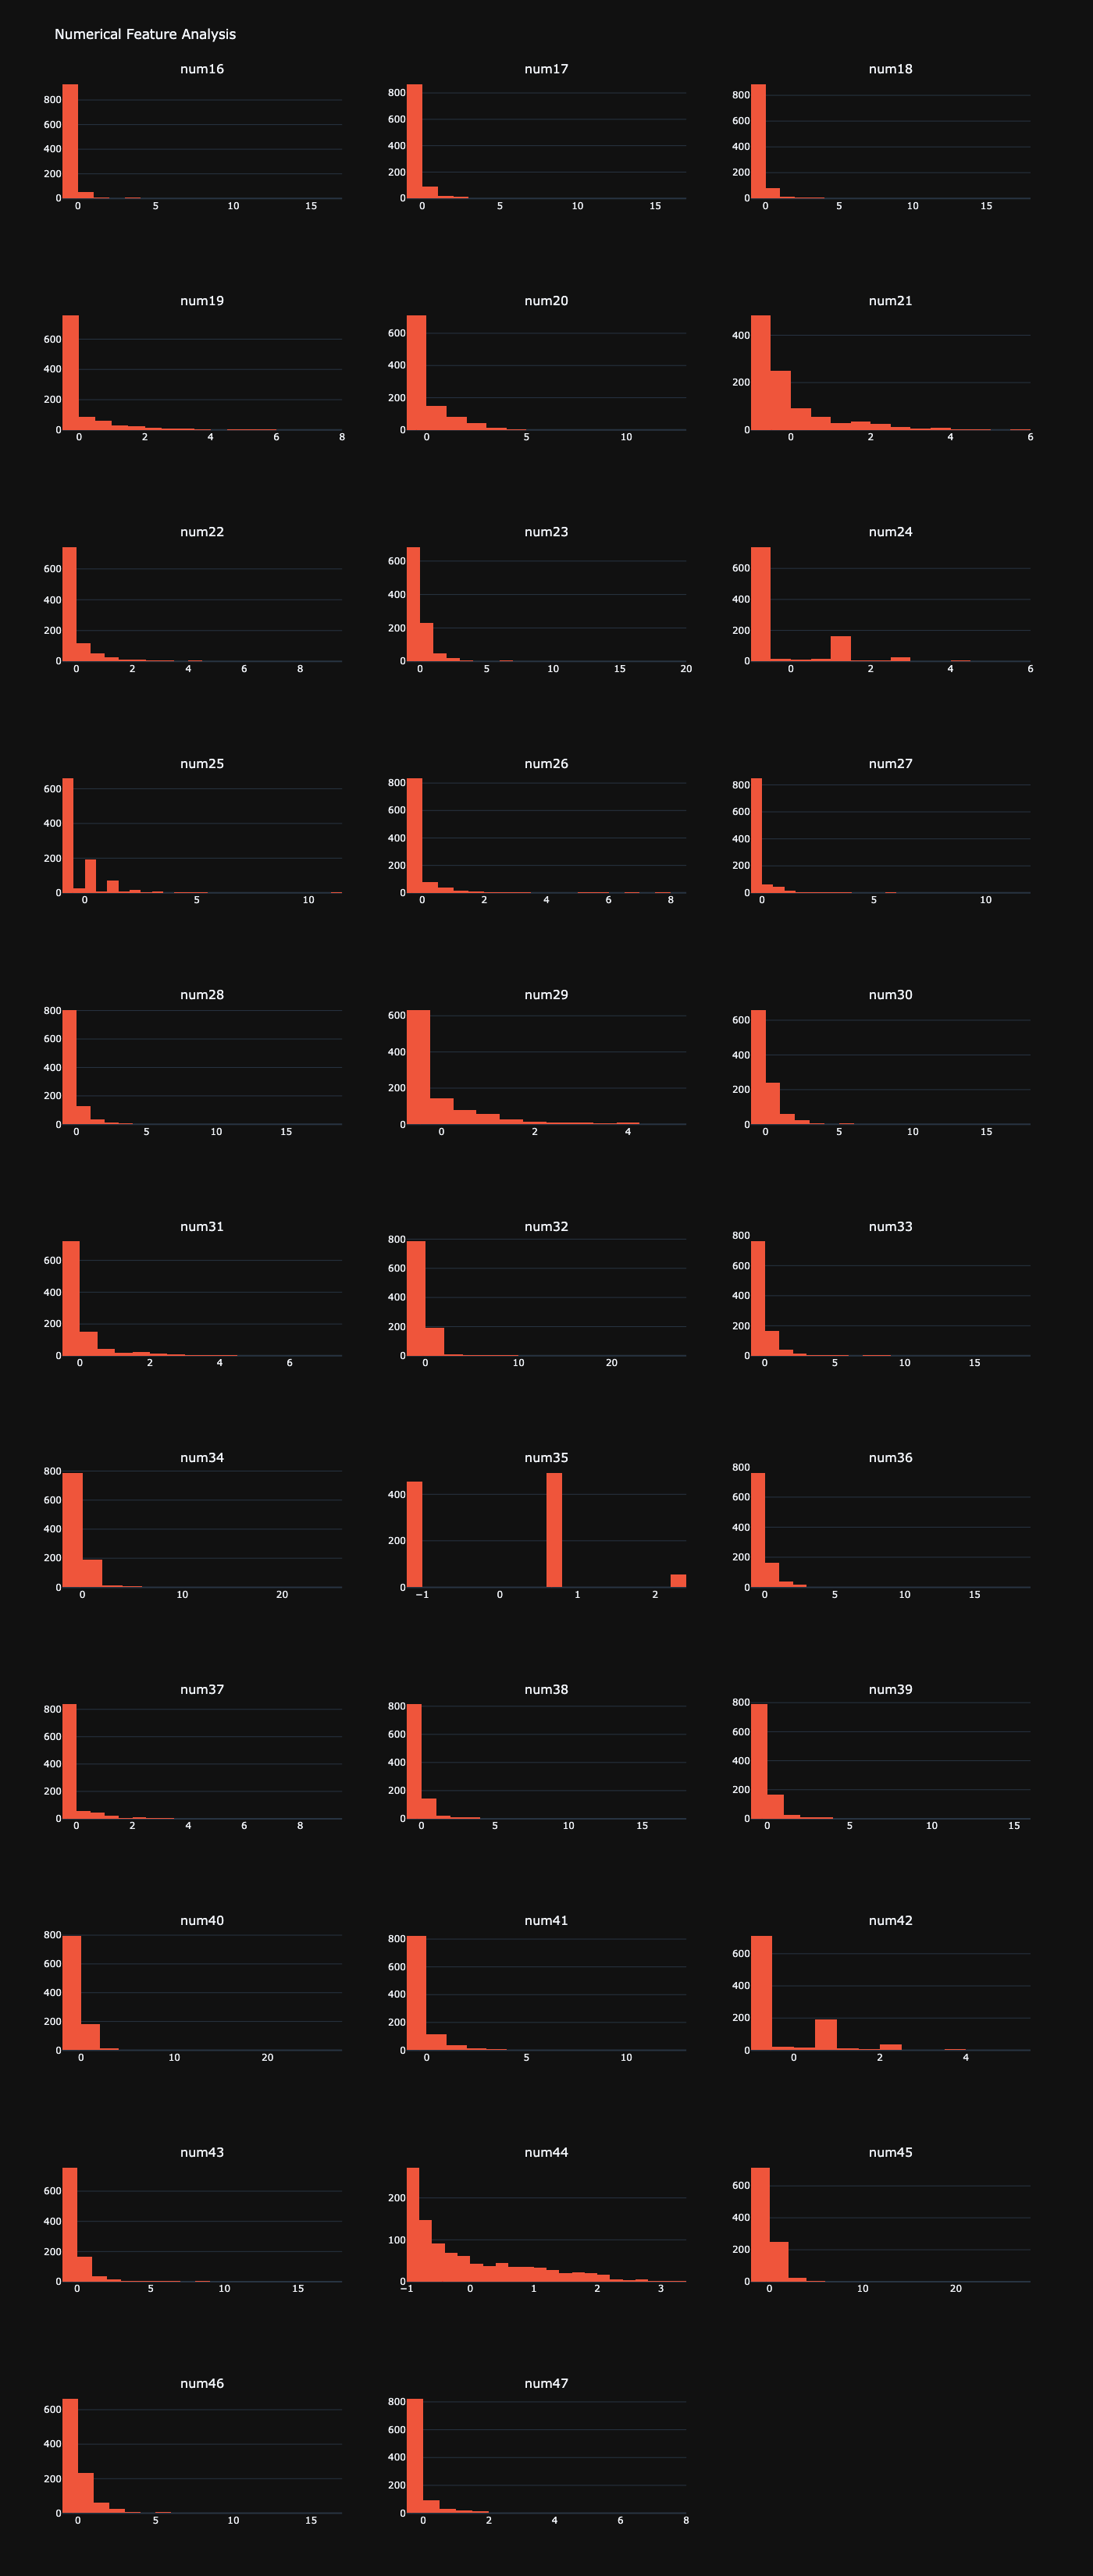

In [81]:
numerical_cols = numerical_columns.value
categorical_cols = categorical_columns.value

skewness_num = [skew(emp_df[col]) for col in numerical_cols]

border_num = [False for _ in range(len(numerical_cols))]
border_cat = [True for _ in range(len(categorical_cols))]

num_rows = (len(numerical_cols) + 2) // 3
fig_num = make_subplots(rows=num_rows, cols=3,
                       subplot_titles=[f"{col}" for col in numerical_cols])

for idx, col in enumerate(numerical_cols):
    row = (idx // 3) + 1
    col_num = (idx % 3) + 1

    fig_num.add_trace(
        go.Histogram(
            x=emp_df[col],
            name=col,
            nbinsx=25,
            marker_color='#EF553B' if 0.3 < abs(skewness_num[idx]) else '#2A5C7D'
        ),
        row=row, col=col_num
    )

    median = emp_df[col].median()
    fig_num.add_shape(
        type="line",
        x0=median,
        x1=median,
        y0=0,
        y1=1,
        xref=f"x{idx+1}",
        yref=f"y{idx+1}",
        line=dict(color="red", width=1, dash="dot")
    )


fig_num.update_layout(
    height=300*num_rows,
    showlegend=False,
    title_text="Numerical Feature Analysis",
    margin=dict(t=100)
)


chisqures_cat = [chisquare(emp_df[col].value_counts().values.tolist()).pvalue for col in categorical_cols]

cat_rows = (len(categorical_cols) + 2) // 3
fig_cat = make_subplots(rows=cat_rows, cols=3,
                       subplot_titles=[f"{col}" for col in categorical_cols])

for idx, col in enumerate(categorical_cols):
    row = (idx // 3) + 1
    col_num = (idx % 3) + 1
    counts = emp_df[col].value_counts().reset_index()

    fig_cat.add_trace(
        go.Bar(
            x=counts[col],
            y=counts['count'],
            name=col,
            marker_color='#EF553B' if chisqures_cat[idx] < 1e-50  else '#2A5C7D',
            hovertemplate="<b>%{x}</b><br>Count: %{y}<extra></extra>",
        ),
        row=row, col=col_num
    )

fig_cat.update_xaxes(showticklabels=False)

fig_cat.update_layout(
    height=300*cat_rows,
    showlegend=False,
    title_text="Categorical Feature Analysis",
    margin=dict(t=100)
)


img_fig_num = fig_num.to_image(format="png", width=1400)
img_fig_cat = fig_cat.to_image(format="png", width=1400)

Image(img_fig_num)

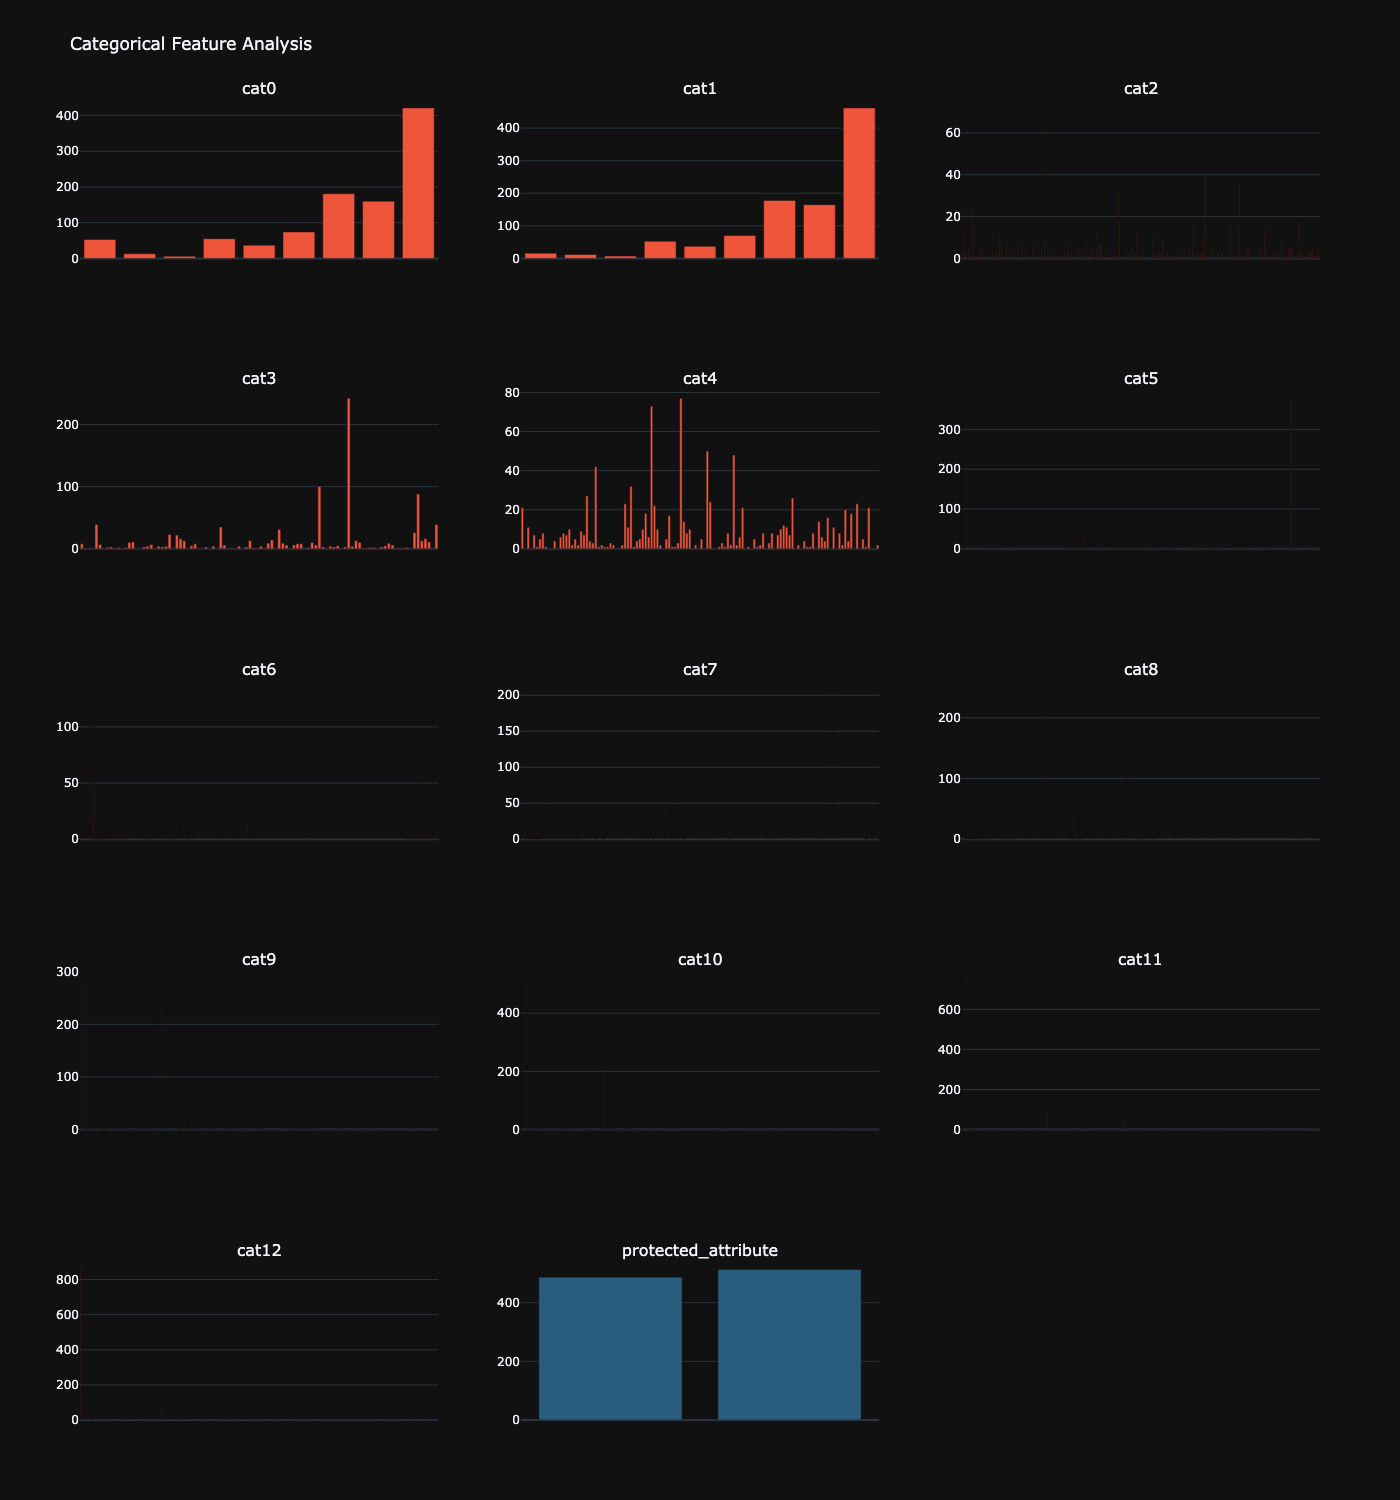

In [82]:
Image(img_fig_cat)

## Model Performance Analysis
After training a Grid Search model, additional graphs are generated to evaluate prediction patterns, class performance, and feature correlation. These insights help assess fairness and model behavior.

---

1. Prediction Patterns (Confusion Matrix)
    This matrix visualizes actual vs. predicted outcomes, where:
    - Rows represent actual values (true/false)
    - Columns represent predicted values (true/false)
    - Darker blue indicates higher values (closer to 100), meaning stronger concentration in that category
    ##### What to look for & why:
    - **More concentration on the diagonal (true positives & true negatives)** → Indicates good model performance, meaning correct predictions are frequent.
    - **Off-diagonal values (false positives & false negatives) are high** → Suggests the model is making mistakes more often, which may lead to fairness issues.
    - **More false positives (predicted true but actually false)** → If sensitive groups are affected, this could result in wrongful decisions (e.g., an unfair rejection or approval).
    - **More false negatives (predicted false but actually true)** → Indicates missed opportunities, which may disproportionately impact underrepresented groups.
    💡Takeaway: If false positives or false negatives are significantly imbalanced across different groups, fairness adjustments may be required, such as reweighting data or adjusting decision thresholds.
2. Class Performance Radar (Recall, Precision, F1-Score)
    This radar chart visualizes model performance metrics across different classes:
    - **Recall** → Measures how well the model identifies actual positives (high recall means fewer false negatives).
    - **Precision** → Measures how many of the predicted positives were actually correct (high precision means fewer false positives).
    - **F1-Score** → Balances precision and recall for a combined assessment.
    ##### What to look for & why:
    - **Balanced scores across all three metrics** → Indicates a well-performing model with fair treatment across classes.
    - **Low recall but high precision** → Means the model is very conservative, only predicting positives when it’s very confident but missing many actual positives. This could be unfair if it leads to exclusion of certain groups.
    - **High recall but low precision** → Suggests the model predicts positives too often, leading to many false positives, which can also be problematic in fairness-sensitive applications.
    - **One class performing significantly worse** → Could indicate dataset imbalance, where the model learns patterns favoring the majority class.
    💡   Takeaway: If performance varies significantly between classes, balancing the dataset or adjusting model thresholds can help improve fairness.

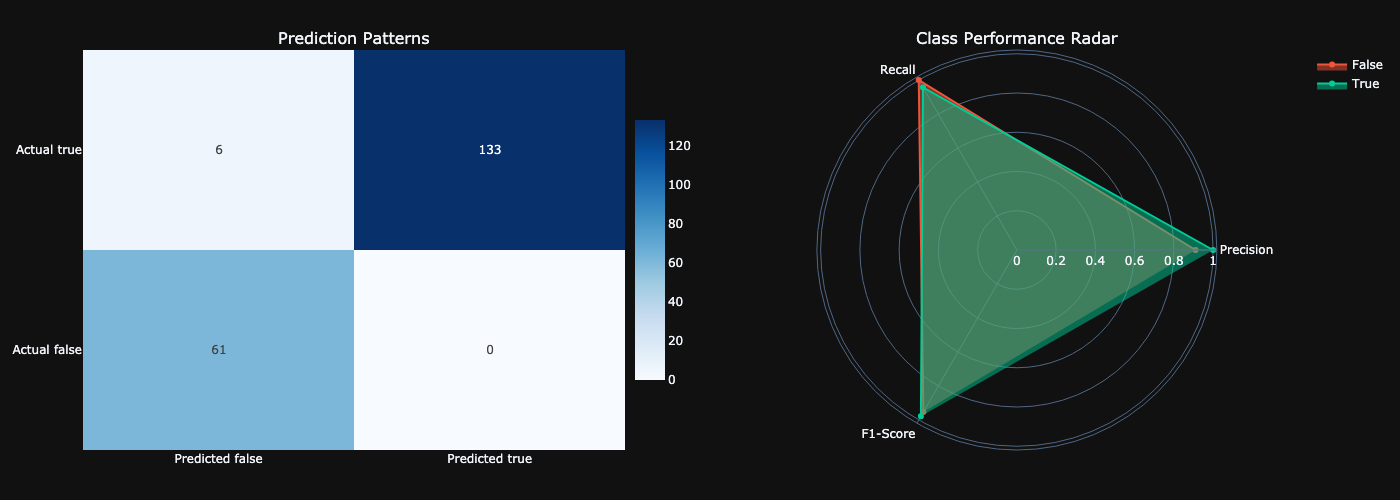

In [83]:
# Create combined visualization
final_fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "heatmap"}, {"type": "scatterpolar"}]],
    subplot_titles=('Prediction Patterns', 'Class Performance Radar')
)

for trace in conf_fig.data:
    final_fig.add_trace(trace, row=1, col=1)

for trace in metrics_fig.data:
    final_fig.add_trace(trace, row=1, col=2)

final_fig.update_layout(
    height=500,
    showlegend=True,
    margin=dict(l=50, r=50, b=50, t=50)
)

img_final_fig = final_fig.to_image(format="png", width=1400)
Image(img_final_fig)

3. Feature Correlation (Prediction Attribute Impact)
    This heatmap shows how strongly each attribute correlates with the prediction outcome:
    - **Blue colors** → Indicate weak or negative correlation.
    - **Red colors** → Indicate strong positive correlation.
    - **Darker shades** → Represent stronger correlation strength.
    ##### What to look for & why:
    - **Features with extreme correlation (very red or very blue)** → May dominate predictions, potentially introducing bias. If a sensitive attribute (e.g., gender, race) has a high correlation, the model may be making unfair decisions based on it.
    - **Low correlation for important attributes** → Suggests the model is not effectively using those features, possibly missing critical information.
    - **Multiple highly correlated attributes** → Could indicate redundancy, where one feature indirectly represents another. This can cause fairness issues if an indirectly correlated sensitive feature influences decisions.
    💡 Takeaway: If a sensitive attribute is highly correlated with the prediction, fairness interventions such as reweighting, debiasing techniques, or removing proxy variables may be necessary.

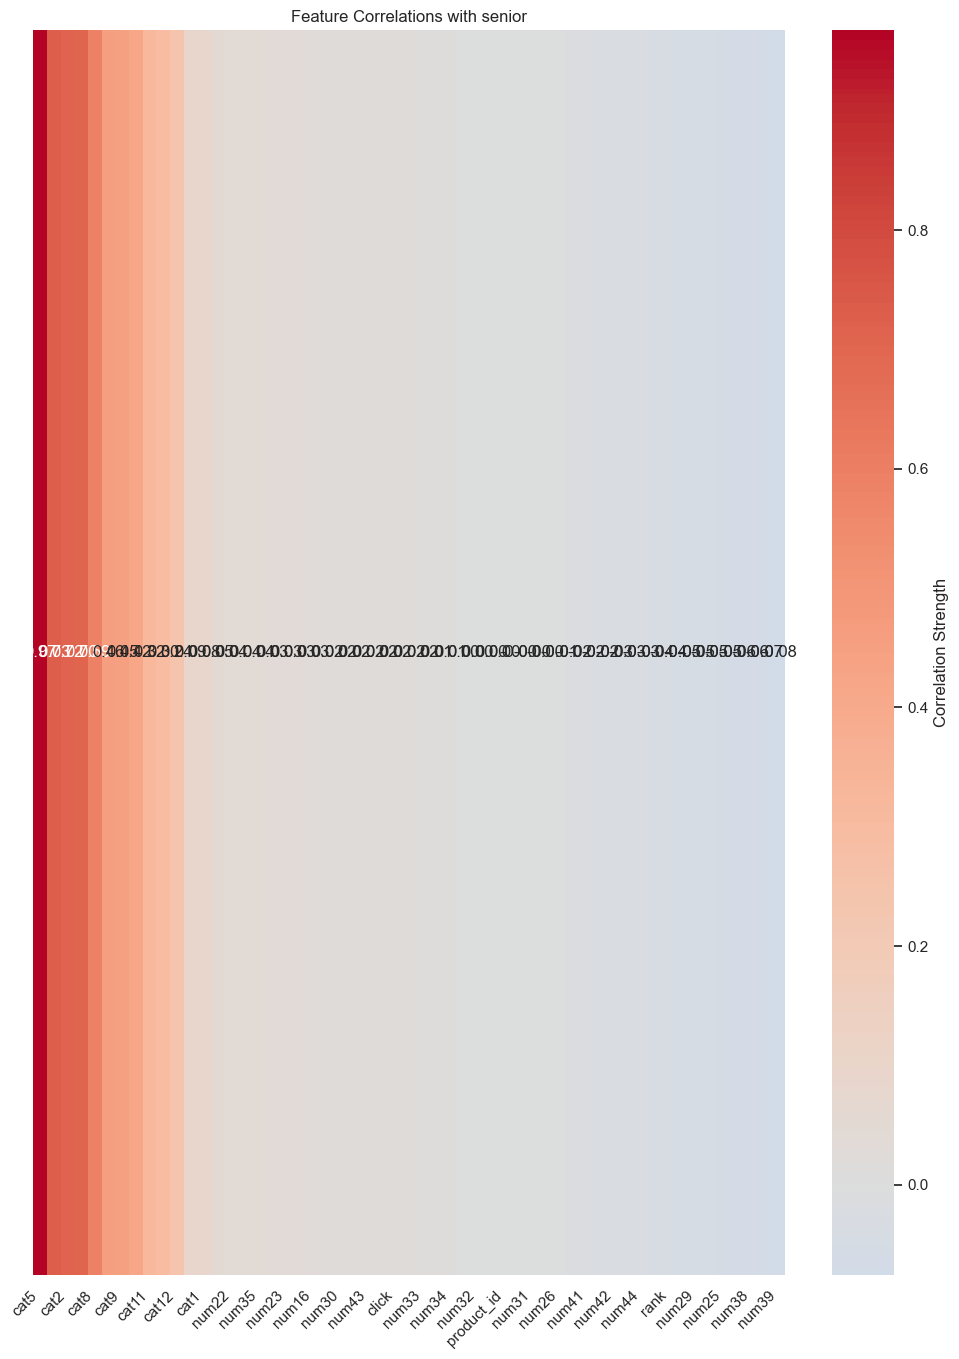

In [84]:
plt.figure(figsize=(10, 0.25 * len(corr_series)))
sns.heatmap(corr_series.to_frame().T,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt=".2f",
            cbar_kws={'label': 'Correlation Strength'})

plt.title(f"Feature Correlations with {prediction_column.value}")
plt.yticks([])  # Remove redundant y-axis label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Fairness Analysis & Protected Attribute Impact
These graphs focus on how fairness is distributed across protected attributes and whether the model exhibits bias toward specific groups.

---

1. Protected Attribute(s) Performance Breakdown
This line graph represents classification accuracy across different protected attribute groups.
- **Green areas indicate high accuracy** → The model performs well for those groups.
- **Red areas indicate lower accuracy** → The model struggles with classification for those groups.
##### What to look for & why:
- **Uneven accuracy across groups** → If accuracy varies significantly, some groups receive less reliable predictions, which can lead to fairness concerns.
- **Red-dominant sections** → Suggest that the model systematically underperforms for certain protected groups, potentially leading to discriminatory outcomes.
- **More green overall** → Indicates a more equitable model, meaning predictions are consistent across groups.
💡 Takeaway: If one group has significantly lower accuracy, consider balancing the dataset, adjusting model thresholds, or applying fairness-aware techniques to ensure fairer predictions.

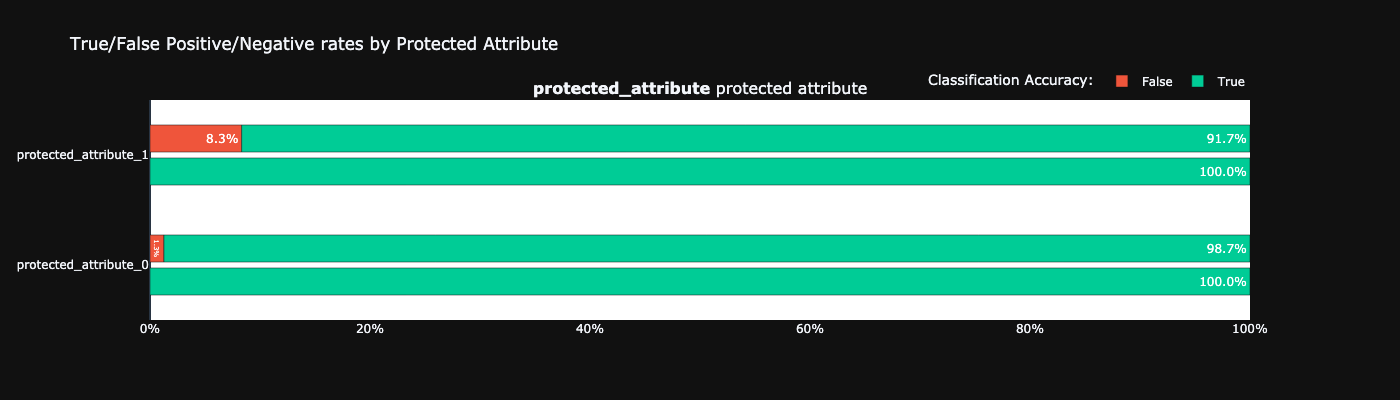

In [85]:
img_tprtnr_fig = tprtnr_fig.to_image(format="png", width=1400)
Image(img_tprtnr_fig)

2. Top Correlation with Protected Values
    This boxplot visualizes how strongly each feature correlates with protected attributes (e.g., gender, race, age).
    - **Values near** ±1 → Indicate a strong correlation, meaning the feature is highly influenced by the protected attribute.
    - **Values around 0** → Indicate weak correlation, meaning the feature is independent of the protected attribute.
    ##### What to look for & why:
    - **Features with extreme correlation (close to -1 or +1)** → Suggest that protected attributes may be indirectly influencing predictions, which can introduce bias.
    - **High correlation for non-sensitive attributes** → Could indicate proxy bias, where a seemingly neutral attribute is actually a disguised version of a protected feature.
    - **Balanced, low correlations (closer to 0)** → Suggest a more fairness-aligned dataset, as predictions are less likely to be skewed by sensitive variables.
    💡 Takeaway: If a protected attribute has a strong correlation with key features, consider removing proxy attributes, reweighting data, or using fairness-aware modeling techniques to mitigate bias.


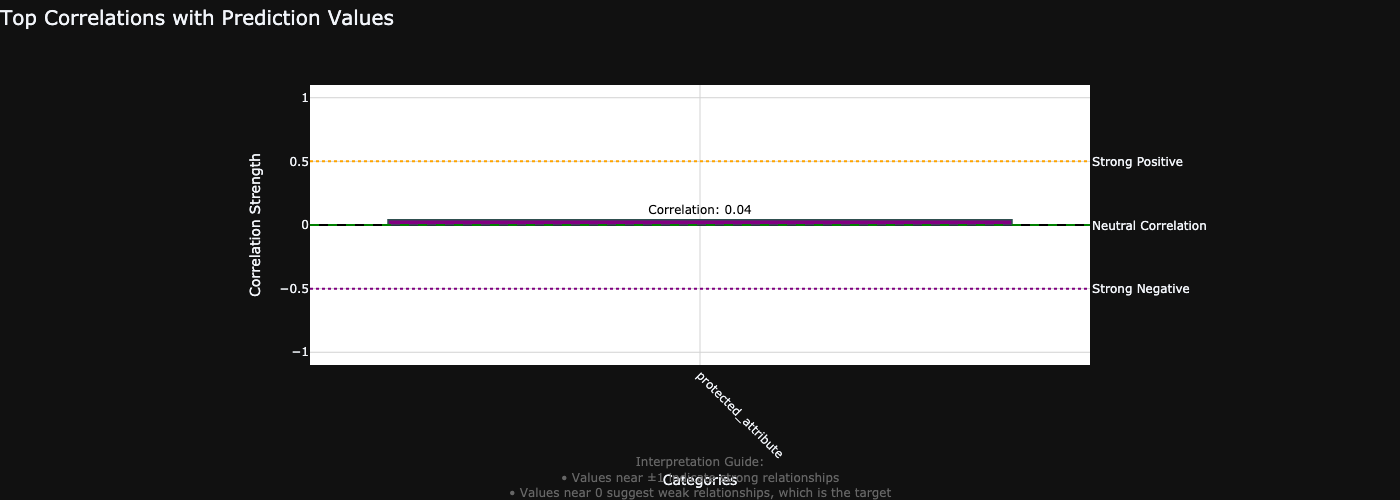

In [86]:
img_corr_fig = corr_fig.to_image(format="png", width=1400)
Image(img_corr_fig)

3. Fairness Analytics: Statistical Parity Difference
    This visualization evaluates fairness using Statistical Parity Difference (SPD):
    - **Attributes within the green threshold** → The model treats groups fairly, as the difference in selection rates between groups is within an acceptable range.
    - **Attributes outside the threshold (red areas)** → Indicate bias, meaning certain groups are significantly more or less likely to receive positive predictions.
    ##### What to look for & why:
    - **Green attributes (fair predictions)** → Suggests the model does not favor one group disproportionately.
    - **Red attributes (bias detected)** → Indicate that a protected group is being disadvantaged or privileged unfairly. This may be due to dataset imbalance or model bias.
    - **The further from the threshold, the more severe the bias** → Large deviations mean the model's decisions are disproportionately influenced by a sensitive attribute.
    💡 Takeaway: If an attribute is flagged red, interventions like rebalancing the dataset, adjusting prediction thresholds, or applying fairness constraints may be necessary to reduce discrimination.

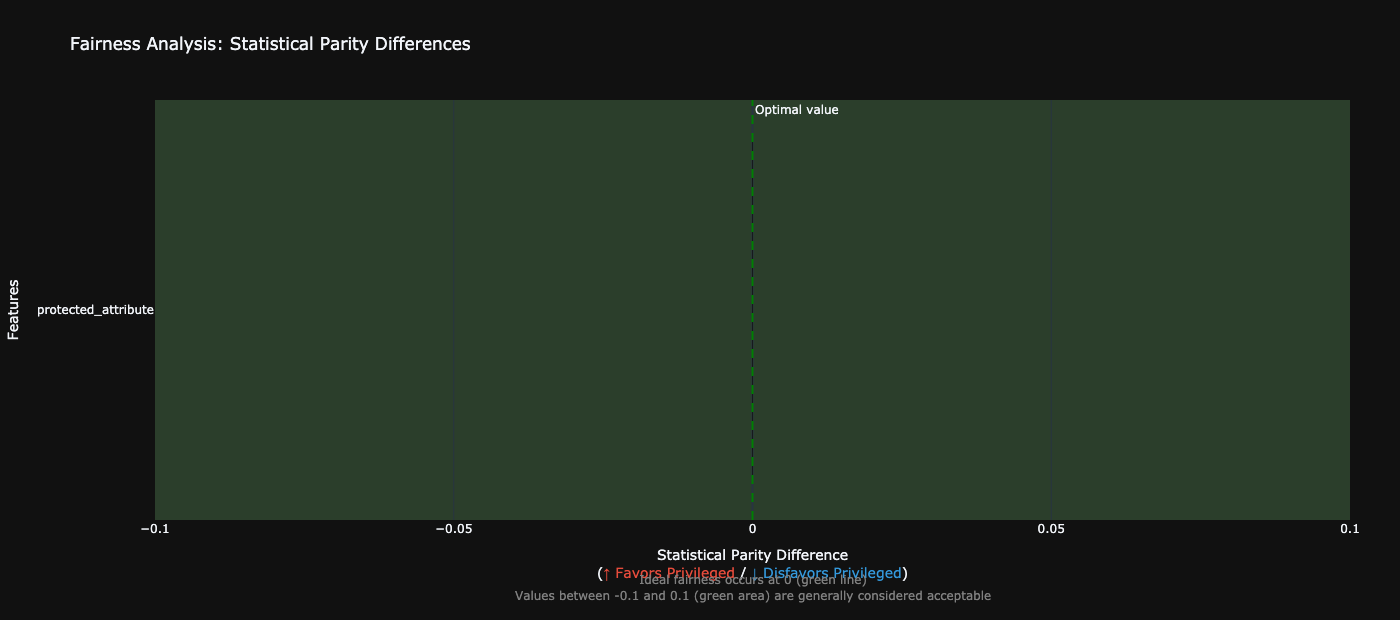

In [87]:
img_parity_fig = parity_fig.to_image(format="png", width=1400)
Image(img_parity_fig)

# Summary & Next Steps
This report provides a detailed fairness analysis of your dataset and model. By examining prediction patterns, class performance, feature correlations and fairness metrics, you can identify and mitigate biases before deploying your model.

##### Key takeaways:
- ✅ Balanced numerical and categorical distributions lead to more reliable models.
- 🚨 High correlation between sensitive attributes and predictions may indicate bias.
- ⚖️ Unequal accuracy or statistical parity differences suggest fairness adjustments may be needed.

For best results, consider rebalancing data, adjusting thresholds, or applying fairness-aware techniques based on these insights.

🔗 GitHub Repository (fork it): https://github.com/Bence749/FairnessLens
Thank you for using FairnessLens—helping make AI more transparent, ethical, and fair! 🚀